# 野球チームの『攻撃力』と『守備力』を計算して、4つのタイプに分類・可視化する分析ツール

=== 各チームタイプ統計分析 ===
総チーム数: 12

【攻守兼備型】チーム数: 2
平均勝率: 0.549
平均OPS: 0.679
平均ERA: 2.98
含まれるチーム: オリックス, ソフトバンク
--------------------------------------------------
【強攻弱守型】チーム数: 3
平均勝率: 0.500
平均OPS: 0.683
平均ERA: 3.41
含まれるチーム: 巨人, ヤクルト, DeNA
--------------------------------------------------
【弱攻強守型】チーム数: 4
平均勝率: 0.484
平均OPS: 0.638
平均ERA: 3.01
含まれるチーム: 中日, 阪神, 西武, 日本ハム
--------------------------------------------------
【低迷型】チーム数: 3
平均勝率: 0.487
平均OPS: 0.656
平均ERA: 3.43
含まれるチーム: 広島, ロッテ, 楽天
--------------------------------------------------


/var/folders/fm/0qxx_2wn44jfmgzgcs41r4s40000gn/T/ipykernel_53655/396190722.py:246: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


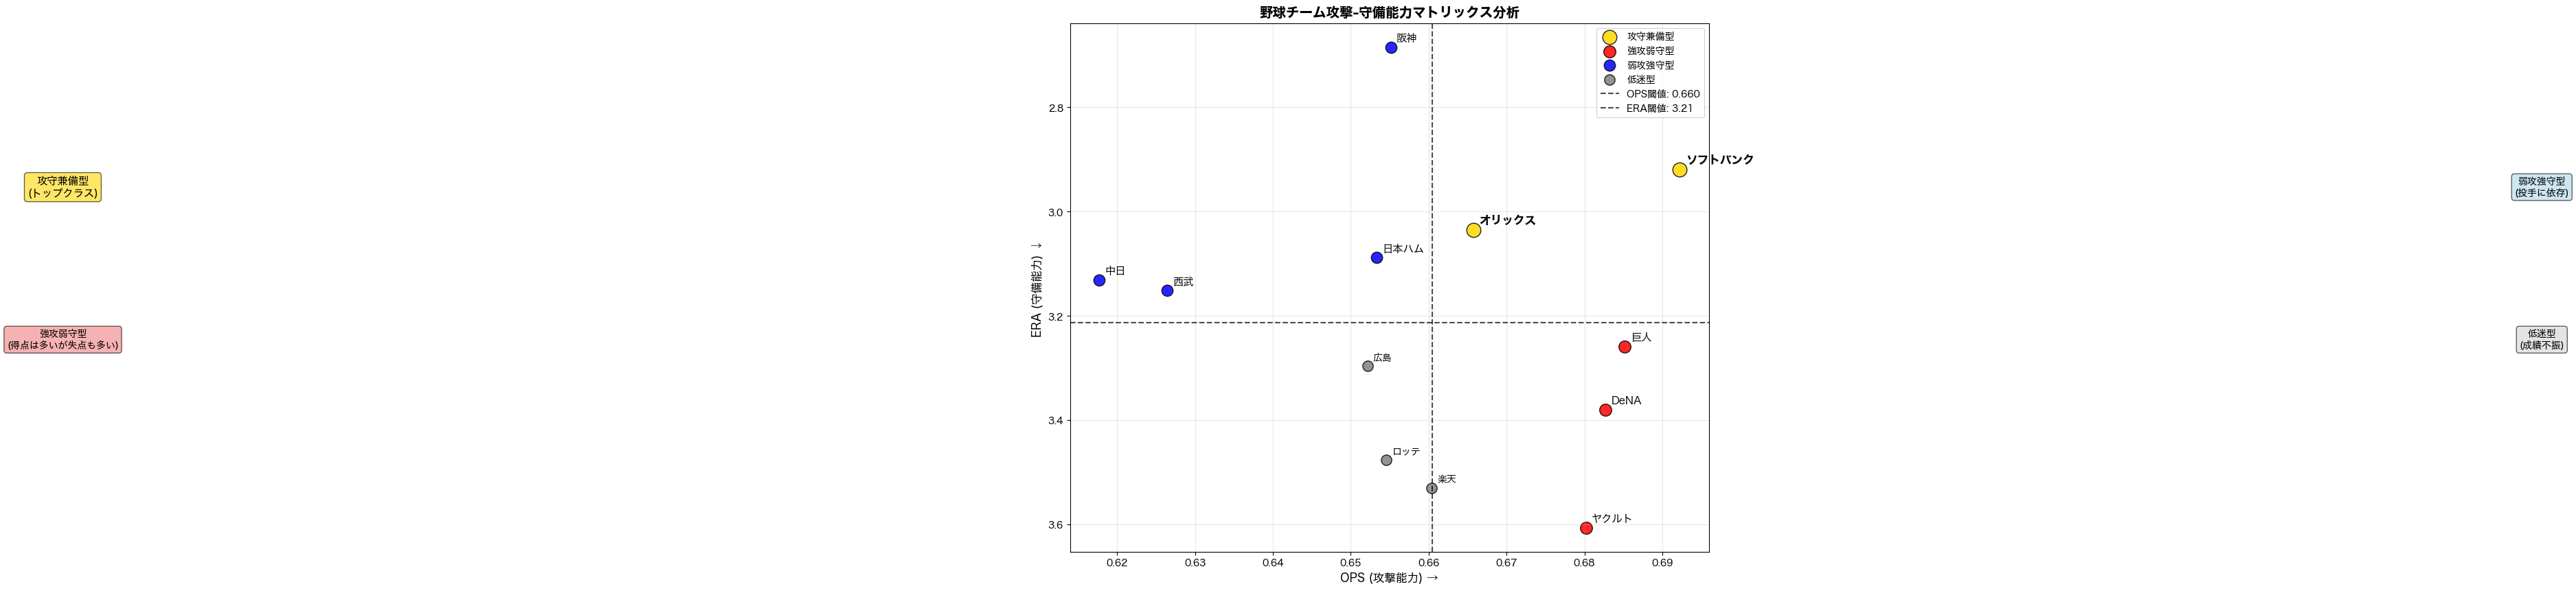


=== 最適閾値の検索 ===
最適OPS閾値: 0.667
最適ERA閾値: 3.10
攻守兼備型チームの平均勝率: 0.561

=== 最適閾値を使用した再分析 ===
=== 各チームタイプ統計分析 ===
総チーム数: 12

【攻守兼備型】チーム数: 1
平均勝率: 0.561
平均OPS: 0.692
平均ERA: 2.92
含まれるチーム: ソフトバンク
--------------------------------------------------
【強攻弱守型】チーム数: 3
平均勝率: 0.500
平均OPS: 0.683
平均ERA: 3.41
含まれるチーム: 巨人, ヤクルト, DeNA
--------------------------------------------------
【弱攻強守型】チーム数: 3
平均勝率: 0.529
平均OPS: 0.658
平均ERA: 2.94
含まれるチーム: 阪神, 日本ハム, オリックス
--------------------------------------------------
【低迷型】チーム数: 5
平均勝率: 0.469
平均OPS: 0.642
平均ERA: 3.32
含まれるチーム: 中日, 広島, 西武, ロッテ, 楽天
--------------------------------------------------

分析結果を保存しました: team_analysis_results.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os

# 日本語フォント設定
# Mac用のフォント「ヒラギノ角ゴシック」を指定します
plt.rcParams['font.sans-serif'] = ['Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False    # マイナス記号を正常に表示するため


def read_csv_with_fallback(path, encodings=None, **kwargs):
    """
    複数のエンコーディングでCSVを読み込む
    デフォルトの試行順序：shift_jis, cp932, utf-8, utf-8-sig, gbk, cp1252, latin1
    kwargsを通じてpandas.read_csvの他のパラメータを渡すことができる
    """
    if encodings is None:
        # 日本語/一般的なWindowsエンコーディングを優先し、その後UTF-8とその他のエンコーディングを試す
        encodings = ['shift_jis', 'cp932', 'utf-8', 'utf-8-sig', 'gbk', 'cp1252', 'latin1']

    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except UnicodeDecodeError as e:
            last_err = e
            # 次のエンコーディングを試す
            continue
        except Exception as e:
            # エンコーディングエラー以外（ファイルが存在しないなど）は直接スロー
            raise

    # すべて失敗した場合、最後のエンコーディングエラーをスロー
    raise last_err

class BaseballTeamAnalyzer:
    def __init__(self, stats_bat_path, stats_pit_path, games_path):
        """
        アナライザーの初期化
        """
        # エンコーディングフォールバック付き読み込み関数を使用
        self.stats_bat = read_csv_with_fallback(stats_bat_path)
        self.stats_pit = read_csv_with_fallback(stats_pit_path)
        self.games = read_csv_with_fallback(games_path)
        
    def calculate_team_win_rate(self):
        """
        各チームの勝率を計算
        """
        win_records = []
        
        for _, game in self.games.iterrows():
            home_team = game['home_team_id']
            away_team = game['away_team_id']
            home_score = game['home_team_score']
            away_score = game['away_team_score']
            
            # 勝者の決定
            if home_score > away_score:
                win_records.append({'team_id': home_team, 'win': 1, 'game': 1})
                win_records.append({'team_id': away_team, 'win': 0, 'game': 1})
            elif away_score > home_score:
                win_records.append({'team_id': home_team, 'win': 0, 'game': 1})
                win_records.append({'team_id': away_team, 'win': 1, 'game': 1})
            else:
                # 引き分け、両方0.5勝とする
                win_records.append({'team_id': home_team, 'win': 0.5, 'game': 1})
                win_records.append({'team_id': away_team, 'win': 0.5, 'game': 1})
        
        win_df = pd.DataFrame(win_records)
        team_win_rate = win_df.groupby('team_id').agg({
            'win': 'sum',
            'game': 'sum'
        }).reset_index()
        
        team_win_rate['win_rate'] = team_win_rate['win'] / team_win_rate['game']
        return team_win_rate

    def calculate_team_ops(self):
        """
        各チームのOPS（出塁率+長打率）を計算
        """
        # チーム別に打撃データの合計を計算
        team_batting = self.stats_bat.groupby('team_id').agg({
            'h': 'sum',
            'h1b': 'sum', 
            'h2b': 'sum',
            'h3b': 'sum',
            'hr': 'sum',
            'bb': 'sum',
            'hbp': 'sum',
            'ab': 'sum',
            'pa': 'sum',
            'team_name': 'first'  # チーム名を取得
        }).reset_index()
        
        # 打撃指標の計算
        team_batting['avg'] = team_batting['h'] / team_batting['ab']  # 打率
        team_batting['obp'] = (team_batting['h'] + team_batting['bb'] + team_batting['hbp']) / team_batting['pa']  # 出塁率
        team_batting['slg'] = (team_batting['h1b'] + 2*team_batting['h2b'] + 3*team_batting['h3b'] + 4*team_batting['hr']) / team_batting['ab']  # 長打率
        team_batting['ops'] = team_batting['obp'] + team_batting['slg']  # OPS
        
        return team_batting[['team_id', 'team_name', 'avg', 'obp', 'slg', 'ops']]

    def calculate_team_era(self):
        """
        各チームの防御率(ERA)を計算
        """
        team_pitching = self.stats_pit.groupby('team_id').agg({
            'er': 'sum',
            'ip': 'sum',
            'team_name': 'first'
        }).reset_index()
        
        # 防御率の計算 ERA = (ER × 9) / IP
        team_pitching['era'] = (team_pitching['er'] * 9) / team_pitching['ip']
        
        return team_pitching[['team_id', 'team_name', 'era']]

    def build_offense_defense_model(self, ops_threshold=None, era_threshold=None):
        """
        攻撃-守備モデルの構築
        """
        # 各指標の計算
        win_rates = self.calculate_team_win_rate()
        ops_data = self.calculate_team_ops()
        era_data = self.calculate_team_era()
        
        # データの結合
        team_data = pd.merge(win_rates, ops_data, on='team_id')
        team_data = pd.merge(team_data, era_data, on='team_id')

        # 結合後にteam_name_x / team_name_yなどの重複列が発生する可能性があるため、`team_name`に統一
        if 'team_name' not in team_data.columns:
            if 'team_name_x' in team_data.columns:
                team_data['team_name'] = team_data['team_name_x']
            elif 'team_name_y' in team_data.columns:
                team_data['team_name'] = team_data['team_name_y']

        # 可能性のある重複列を削除
        for col in ['team_name_x', 'team_name_y']:
            if col in team_data.columns:
                team_data.drop(columns=[col], inplace=True)
        
        # 閾値が提供されていない場合、リーグ平均を基準として使用
        if ops_threshold is None:
            ops_threshold = team_data['ops'].mean()
        if era_threshold is None:
            era_threshold = team_data['era'].mean()
        
        # チームの分類
        def classify_team(row):
            if row['ops'] >= ops_threshold and row['era'] <= era_threshold:
                return '攻守兼備型'
            elif row['ops'] >= ops_threshold and row['era'] > era_threshold:
                return '強攻弱守型'
            elif row['ops'] < ops_threshold and row['era'] <= era_threshold:
                return '弱攻強守型'
            else:
                return '低迷型'
        
        team_data['team_type'] = team_data.apply(classify_team, axis=1)
        
        return team_data, ops_threshold, era_threshold

    def plot_offense_defense_matrix(self, team_data, ops_threshold, era_threshold):
        """
        攻撃-守備四象限図の描画
        """
        plt.figure(figsize=(12, 10))
        
        # カラーマッピングの定義
        colors = {
            '攻守兼備型': 'gold',
            '強攻弱守型': 'red', 
            '弱攻強守型': 'blue',
            '低迷型': 'gray'
        }
        
        # 散布図の作成
        # より明確な点のサイズとラベル：優勝クラスは大きく目立つように
        sizes = {
            '攻守兼備型': 220,
            '強攻弱守型': 160,
            '弱攻強守型': 140,
            '低迷型': 120
        }
        label_fontsizes = {
            '攻守兼備型': 12,
            '強攻弱守型': 11,
            '弱攻強守型': 11,
            '低迷型': 10
        }

        for team_type, color in colors.items():
            mask = team_data['team_type'] == team_type
            plt.scatter(team_data.loc[mask, 'ops'], 
                       team_data.loc[mask, 'era'],
                       c=color, label=team_type, s=sizes.get(team_type, 100), alpha=0.85, edgecolors='k')

            # チームラベルの追加（大きく、太字で強調）
            for _, row in team_data[mask].iterrows():
                plt.annotate(row['team_name'], 
                             (row['ops'], row['era']),
                             xytext=(6, 6), textcoords='offset points',
                             fontsize=label_fontsizes.get(team_type, 10),
                             fontweight='bold' if team_type == '攻守兼備型' else 'normal',
                             alpha=0.95)
        
        # 閾値線の追加
        plt.axvline(x=ops_threshold, color='black', linestyle='--', alpha=0.7, label=f'OPS閾値: {ops_threshold:.3f}')
        plt.axhline(y=era_threshold, color='black', linestyle='--', alpha=0.7, label=f'ERA閾値: {era_threshold:.2f}')
        
        # 軸の設定
        plt.xlabel('OPS (攻撃能力) →', fontsize=12)
        plt.ylabel('ERA (守備能力) ↓', fontsize=12)
        plt.title('野球チーム攻撃-守備能力マトリックス分析', fontsize=14, fontweight='bold')
        
        # Y軸を反転（ERAは低い方が良いため）
        plt.gca().invert_yaxis()
        
        # グリッドと凡例の追加
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # 象限注釈の追加
        plt.text(team_data['ops'].max() * 0.7, team_data['era'].min() * 1.1, 
            '攻守兼備型\n(トップクラス)', ha='center', va='center', 
            fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="gold", alpha=0.6))
        
        plt.text(team_data['ops'].max() * 0.7, team_data['era'].max() * 0.9, 
            '強攻弱守型\n(得点は多いが失点も多い)', ha='center', va='center', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.6))
        
        plt.text(team_data['ops'].min() * 1.3, team_data['era'].min() * 1.1, 
            '弱攻強守型\n(投手に依存)', ha='center', va='center', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.6))
        
        plt.text(team_data['ops'].min() * 1.3, team_data['era'].max() * 0.9, 
            '低迷型\n(成績不振)', ha='center', va='center', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.6))
        
        plt.tight_layout()
        plt.show()

    def analyze_team_types(self, team_data):
        """
        各チームタイプの特性を分析
        """
        print("=== 各チームタイプ統計分析 ===")
        print(f"総チーム数: {len(team_data)}")
        print()
        
        for team_type in ['攻守兼備型', '強攻弱守型', '弱攻強守型', '低迷型']:
            type_data = team_data[team_data['team_type'] == team_type]
            if len(type_data) > 0:
                print(f"【{team_type}】チーム数: {len(type_data)}")
                print(f"平均勝率: {type_data['win_rate'].mean():.3f}")
                print(f"平均OPS: {type_data['ops'].mean():.3f}")
                print(f"平均ERA: {type_data['era'].mean():.2f}")
                print("含まれるチーム:", ", ".join(type_data['team_name'].tolist()))
                print("-" * 50)

    def find_optimal_thresholds(self, team_data):
        """
        最適なOPSとERA閾値を検索
        """
        best_score = 0
        best_ops_threshold = 0
        best_era_threshold = 0
        
        # 異なる閾値の組み合わせをテスト
        ops_range = np.linspace(team_data['ops'].quantile(0.3), team_data['ops'].quantile(0.7), 20)
        era_range = np.linspace(team_data['era'].quantile(0.3), team_data['era'].quantile(0.7), 20)
        
        for ops_thresh in ops_range:
            for era_thresh in era_range:
                # チームの分類
                champion_teams = team_data[
                    (team_data['ops'] >= ops_thresh) & 
                    (team_data['era'] <= era_thresh)
                ]
                
                if len(champion_teams) > 0:
                    # 「攻守兼備型」チームの平均勝率をスコアとして計算
                    score = champion_teams['win_rate'].mean()
                    
                    if score > best_score:
                        best_score = score
                        best_ops_threshold = ops_thresh
                        best_era_threshold = era_thresh
        
        return best_ops_threshold, best_era_threshold, best_score

# 使用例
if __name__ == "__main__":
    ''' 各チームの攻撃能力と守備能力、および四象限図を計算 '''
    # アナライザーの初期化（スクリプトの位置からプロジェクトルートの`sourse_file`へのパスを構築）
    base_dir = os.getcwd()
    data_dir = os.path.join(base_dir, 'lecture-sp')

    # パスの指定部分
    analyzer = BaseballTeamAnalyzer(
    stats_bat_path=os.path.join(data_dir, 'stats_bat.csv'),
    stats_pit_path=os.path.join(data_dir, 'stats_pit.csv'),
    games_path=os.path.join(data_dir, 'games.csv')
)
    
    # 基本モデルの構築
    team_data, ops_threshold, era_threshold = analyzer.build_offense_defense_model()
    
    # 基本分析結果の表示
    analyzer.analyze_team_types(team_data)
    
    # マトリックス図の描画
    analyzer.plot_offense_defense_matrix(team_data, ops_threshold, era_threshold)
    
    # 最適閾値の検索
    print("\n=== 最適閾値の検索 ===")
    best_ops, best_era, best_score = analyzer.find_optimal_thresholds(team_data)
    print(f"最適OPS閾値: {best_ops:.3f}")
    print(f"最適ERA閾値: {best_era:.2f}")
    print(f"攻守兼備型チームの平均勝率: {best_score:.3f}")
    
    # 最適閾値を使用して再分類
    print("\n=== 最適閾値を使用した再分析 ===")
    team_data_optimized, _, _ = analyzer.build_offense_defense_model(
        ops_threshold=best_ops, 
        era_threshold=best_era
    )
    analyzer.analyze_team_types(team_data_optimized)
    
    # 結果をCSVに保存
    team_data_optimized.to_csv('team_analysis_results.csv', index=False, encoding='utf-8-sig')
    print("\n分析結果を保存しました: team_analysis_results.csv")